# Object Detection with xt-training

## Notebook Purpose

The notebook serves as a tutorial for using xt-training for the purpose of <b>Object Detection</b>. To help highlight some of the advantages offered by xt-training vs. native Pytorch, we will implement an existing Pytorch tutorial using xt-training. The tutorial can be found [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html). It is recommended that the user read through the tutorial prior to working through this notebook.

Additional Prerequisites.
* This tutorial assumes the basics of the Pytorch ML framework are understood by the user
    * please see [here](https://pytorch.org/tutorials/beginner/basics/intro.html) if you need a refresher
* It is helpful to have at least read through the xt-training "getting started" page [here](https://xt-training.readthedocs.io/en/latest/getting-started/)

We will be highlighting both the Functional and Runner xt-training APIs, which each provide different levels of granularity for managing your model training pipeline.

## Preparing the Datasets/Dataloaders
Prior to implementing the xt-training library for model training, we will need prepare our datasets/dataloaders.

In [1]:
import os

import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xt_training import metrics
from xt_training.utils import functional

Let’s write a `torch.utils.data.Dataset` class for the [PennFudan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset we use. The data can be downloaded [here](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip).

In [2]:
class RCNNDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
# our dataset has two classes only - background and person
num_classes = 2

# use our dataset and defined transformations
dataset = RCNNDataset(
    root='path/to/dataset/PennFudanPed', 
    transforms=transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ])
)
test_ds = RCNNDataset(
    root='path/to/dataset/PennFudanPed', 
    transforms=transforms.ToTensor()
)

# split the dataset in train, valid, and test set
indices = torch.randperm(len(dataset)).tolist()
train_ds = torch.utils.data.Subset(dataset, indices[:100])
valid_ds = torch.utils.data.Subset(dataset, indices[100:120])
test_ds = torch.utils.data.Subset(test_ds, indices[-50:])

In the dataset, label `y` is a dictionary whose values are converted to PyTorch Tensor with the `transforms`. For example, if there are 3 groudtruths in an image, `y['boxes']` should be a Tensor with size `(3, 4)`.

During the enumeration of dataloaders with such labels, an additional batch-dimension will be added to each tensor value. The above-mentioned `y['boxes']` would become a Tensor with size `(1, 3, 4)`. This is not the expected working way of batches and hence causes training errors.

We solve this problem using `collate_fn` to collate samples into correct batches.

In [4]:
def collate_fn(data):
    
    images, targets = zip(*data)
    
    return images, targets

In [5]:
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)

valid_loader = DataLoader(
    valid_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)

test_loaders = {}
test_loaders['test'] = DataLoader(
    test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

## Defining our Model & Optimizer
To have a straight forward example of xt-training, we will use a pre-trained model and just finetune the last layer.

In [6]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# return both loss and detections nomatter in training or evaluation mode,
# so we can use xt-training metrics
model.eager_outputs = lambda l, d: (l, d)

During training, the model returns 4 kinds of losses: `loss_classifier`, `loss_box_reg`, `loss_mask`, and `loss_keypoint`, but return no predictions. And during validation (`model.training==False`), the model only returns the prediction and no loss.

The following ODHandler simply add the value of the 4 losses together as an indication during training.

In [7]:
class ODHandler:
    def __init__(self, callable, default=None):
        self.fn = callable
        self.default = default
    def __call__(self, inputs, y):
        try:
            return self.fn(inputs, y)
        except:
            return self.default

In [8]:
fn = lambda y_pred, loss: sum(l for l in loss.values())
loss_fn = ODHandler(fn, torch.as_tensor(0))

## A Note on Device Management

Typically we would need to move the instantiated model to the GPU explicitly, if that's the resource we want to use (the same goes for our train/test data); however, xt-training's Functional API handles all of the device management for us and assumes we want to be running on a GPU, if available.

In [9]:
# # move model to the right device (already implemented in xt-training)
# model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## xt-training Metrics
Xt-training makes it easy to configure a variety of metrics to keep track of during training. Note that the suite of metrics offered also includes measurements of training time (e.g. Examples per Second) and GPU Utilization and Memory.


We will review how these metrics are reported once we start training the model.

In [10]:
# For the PennFudan dataset, class 0 is background and class 1 is person, 
# and since we only detect person in the image, ap_0 should always be 0.
eval_metrics={
        'eps': metrics.EPS(),
        'ap_0': metrics.AveragePrecision(cls=0, iouthreshold=0.7),
        'ap_1': metrics.AveragePrecision(cls=1, iouthreshold=0.7)
    }

## Model Training with the Functional API
Now we are ready to start training our model with xt-training's functional API. Let's take a look at the functions arguments first.

In [11]:
functional.train?

We will not go into detail on all of the arguments, but the user is encouraged to explore them further.

The xt-trainer functional training API provides the following non-exaustive list of benefits for the user:
* It handles the
    * training loop for us - i.e. we won't need to write code to handle the loop ourselves.
    * saving both the 'best' and 'latest' model checkpoints based on validation loss (or training loss if no validation dataloader is provided)
    * calculating and aggregating a variety of (user configurable) metrics over batches
* In summary, it abstracts away a lot of boiler plate code, allowing ML Engineers and Data Scientists to focus on training models
* It aims to be agnostic of any specific deep learning task and therefore is useful for a variety of domains including computer vision, nlp, and even reinforement learning.

For a more complete understanding of the benefits of using xt-training, please see [here](https://xt-training.readthedocs.io/en/latest/basis/)


In [12]:
save_dir = 'path/to/save/model/log/'

functional.train(
    save_dir=save_dir,
    train_loader=train_loader,
    model=model,
    optimizer=optimizer,
    epochs=2,
    loss_fn=loss_fn,
    overwrite=True,
    val_loader=valid_loader,
    test_loaders=test_loaders,
    device='cuda:0',
    scheduler=lr_scheduler,
    eval_metrics=eval_metrics,
)

Running on device: cuda:0


Initial
----------
test     |    50/50   | loss:    0.0000 | eps:    5.2848 | ap_0:    0.0000 | ap_1:    0.1000   
valid    |    20/20   | loss:    0.0000 | eps:    4.8887 | ap_0:    0.0000 | ap_1:    0.0455   


/home/angran/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float32)).float())) for i in range(dim)]
/home/angran/anaconda3/lib/python3.7/site-packages/torchvision/models/detection/anchor_utils.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image_size[1] // g[1], dtype=torch.int64, device=device)] for g in grid_sizes]
/home/angran/anaconda3/lib/python3.7/site-packages/torch/tensor.py:593: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give i


Epoch 1/2
----------


/home/angran/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


train    |   100/100  | loss:    0.3743 | eps:    7.8984 | ap_0:       nan | ap_1:       nan   
valid    |    20/20   | loss:    0.0000 | eps:    8.8200 | ap_0:    0.0000 | ap_1:    1.0000   

Epoch 2/2
----------
train    |   100/100  | loss:    0.2910 | eps:    7.8534 | ap_0:       nan | ap_1:       nan   
valid    |    20/20   | loss:    0.0000 | eps:   10.0929 | ap_0:    0.0000 | ap_1:    0.2500   

Test
----------
test     |    50/50   | loss:    0.0000 | eps:   10.3696 | ap_0:    0.0000 | ap_1:    1.0000   


<b> Initial Run </b>
* The 'Initial' run is done on the test & validation dataloaders before any paramater updates are done. This is a unique feature of xt-training. This is helpful because it provides a benchmark for performance on the test dataloaders.
* Note that this is done whether this is:
    * a completely untrained model (with randomly initialized weights), or
    * a model that has already been trained (pretrained or loaded from a checkpoint)

<b> Metrics </b>
* For each Epoch, we calculate the metrics for the training and validation dataloaders.
* For the "Initial" run, we calculate the metrics for the test dataloaders.
* By default, we also calculate the metrics for the test dataloaders as the final step in training, however this is configurable by the user.
* As an Epoch is running, you'll notice the metrics continually updating. This is because they are computed as the average over the batches run so far. So, for example, as the accuracy for each batch is calculated, it is averaged over all of the batches run so far. When the epoch is completed, we have the average accuracy for the epoch.

<b> Managing Model Checkpoints </b>
* xt-training handles model saving/checkpointing for the user
* It will always save the 'latest' checkpoint for the model after each epoch
* It will also always save the 'best' model, based on the loss evaluated on the validation dataloader (if provided - otherwise will use the training dataloader). If there is an existing 'best' model, it will be overwritten when a better checkpoint is reached. However, since the `loss_fn` in this example simply sums up the 4 losses from the model itself, which are only available in training mode, the best checkpoint won't be updated. This is the reason we use the 'latest' model in the test process below.

<b> Saved File Types </b>
* <b> ONNX (Open Nueral Network Exchange Format) </b>
    * A full representation of the model. This is a useful format for deploying ML models. See [here](https://towardsdatascience.com/onnx-easily-exchange-deep-learning-models-f3c42100fd77) for some more details. 
* <b> .pt</b>
    * This is the saved state_dict for the model which includes the learnable parameter for each of the model's layers. The state_dict is serialized using Python's pickle utility (See [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for information about saving and loading Pytorch models)

## Model Training with the Runner API
Now we'd like to highlight the more granular control that can be achieved with the Runner API. Remember the Runner API handles the training of a single epoch for us - it is up to the user to define their own training loop.

In [13]:
from xt_training import Runner

device = "cuda" if torch.cuda.is_available() else "cpu"

# With the Runner API, we need to explicitly manage which device our model we be located on
model.to(device)

# instantiate our Runner
runner = Runner(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    batch_metrics=eval_metrics,
    device=device # note that the Runner API will default to using the CPU if not specified
)

# Explicitly put into training mode. Previously the Functional API handled this for us.
model.train()
runner(train_loader) # train for another epoch

train    |   100/100  | loss:    0.2607 | eps:    7.8636 | ap_0:       nan | ap_1:       nan   


Note that when we use our Runner instance as a callable to train an epoch it won't save our model for us. However, the Runner.save_model method is available to us.

## Check the Precision-Recall Curve and Compare the Detections to Groundtruth

In [14]:
import cv2
from collections.abc import Iterable
from matplotlib import pyplot as plt

from xt_training.od_lib.BoundingBox import BoundingBox, BoundingBoxes
from xt_training.od_lib.Evaluator import *
from xt_training.od_lib.utils import *

In [15]:
def detach(y):
    y_tmp = []
    for y_i in y:
        if isinstance(y_i, dict):
            y_i = {k: v.detach().cpu().numpy() for k, v in y_i.items()}
        y_tmp.append(y_i)
    return y_tmp

In [16]:
def getBoundingBoxes(y, bbType=BBType.GroundTruth):
        # Class representing bounding boxes (ground truths and detections)
        bbs = BoundingBoxes()
        for i in range(len(y)):
            y_i = y[i]
            if y_i == None:
                break
            nameOfImage = f'img_{i}'
            for k in range(y_i['boxes'].shape[0]):
                box = y_i['boxes'][k]
                x, y, w, h = box
                idClass = y_i['labels'][k]
                if bbType == BBType.Detected:
                    confidence = y_i['scores'][k]
                else:
                    confidence = None
                bb = BoundingBox(
                    nameOfImage,
                    idClass,
                    x, y, w, h,
                    bbType=bbType,
                    classConfidence=confidence,
                    format=BBFormat.XYWH
                )
                bbs.addBoundingBox(bb)
                
        return bbs

In [17]:
def add_bb_into_image(image, bb, color=(255, 0, 0), thickness=2, label=None):
    r = int(color[0])
    g = int(color[1])
    b = int(color[2])

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontThickness = 1

    x1, y1, x2, y2 = bb
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (b, g, r), thickness)
    # Add label
    if label is not None:
        # Get size of the text box
        (tw, th) = cv2.getTextSize(label, font, fontScale, fontThickness)[0]
        # Top-left coord of the textbox
        (xin_bb, yin_bb) = (x1 + thickness, y1 - th + int(12.5 * fontScale))
        # Checking position of the text top-left (outside or inside the bb)
        if yin_bb - th <= 0:  # if outside the image
            yin_bb = y1 + th  # put it inside the bb
        r_Xin = x1 - int(thickness / 2)
        r_Yin = y1 - th - int(thickness / 2)
        # Draw filled rectangle to put the text in it
        cv2.rectangle(image, (r_Xin, r_Yin - thickness),
                      (r_Xin + tw + thickness * 3, r_Yin + th + int(12.5 * fontScale)), (b, g, r),
                      -1)
        cv2.putText(image, label, (xin_bb, yin_bb), font, fontScale, (0, 0, 0), fontThickness,
                    cv2.LINE_AA)
    return image

In [18]:
ckpt = torch.load('path/to/save/model/log/latest.pt')
model.load_state_dict(ckpt)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [19]:
n = np.random.randint(len(test_loaders['test']))
x, y = test_loaders['test'].dataset[n]

device = 'cuda:0'
x = x.to(device)
y = {k: v.to(device) for k, v in y.items()}

In [20]:
y_pred = model([x]) # should be in a batch
y_pred = y_pred[1]
y_pred = detach(y_pred)
y = detach([y]) # should be in a batch

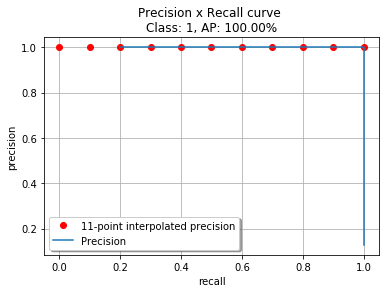

Average precision values per class:

1: 1.000000


In [21]:
# Read txt files containing bounding boxes (ground truth and detections)
boundingboxes_gt = getBoundingBoxes(y)
boundingboxes_det = getBoundingBoxes(y_pred, BBType.Detected)
boundingboxes = BoundingBoxes()
boundingboxes._boundingBoxes = boundingboxes_gt.getBoundingBoxes() + boundingboxes_det.getBoundingBoxes()
# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

evaluator.PlotPrecisionRecallCurve(
    boundingboxes,  # Object containing all bounding boxes (ground truths and detections)
    IOUThreshold=0.7,  # IOU threshold
    method=MethodAveragePrecision.ElevenPointInterpolation,  # As the official matlab code
    showAP=True,  # Show Average Precision in the title of the plot
    showInterpolatedPrecision=True)  # Plot the interpolated precision curve
# Get metrics with PASCAL VOC metrics
metricsPerClass = evaluator.GetPascalVOCMetrics(
    boundingboxes,  # Object containing all bounding boxes (ground truths and detections)
    IOUThreshold=0.7,  # IOU threshold
    method=MethodAveragePrecision.ElevenPointInterpolation)  # As the official matlab code
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
dic = {}
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))
    dic.update({c: average_precision})

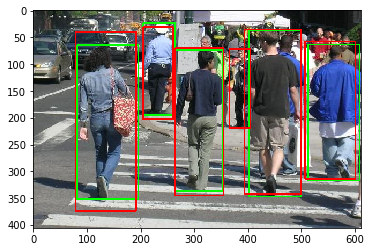

In [22]:
img = x.detach().cpu().numpy()
img = np.transpose(img, [1, 2, 0]) * 255
img = img.astype('uint8')

bbxes = y[0]['boxes']
for bb in bbxes:
#     if bb.getBBType() == BBType.GroundTruth:  # if ground truth
    img = add_bb_into_image(img.copy(), bb, color=(0, 255, 0))  # green
#     else:  # if detection
#         image = add_bb_into_image(image, bb, color=(255, 0, 0))  # red

scores = y_pred[0]['scores']
bbxes = y_pred[0]['boxes']
for bb, score in zip(bbxes, scores):
    if score > 0.7:
        img = add_bb_into_image(img.copy(), bb, color=(0, 0, 255))  # red

# Green boxes: Ground Truth
# Red boxes: Detection
plt.imshow(img)